## Example. Estimating the speed of light

Simon Newcomb's measurements of the speed of light, from

Stigler, S. M. (1977). Do robust estimators work with real data? (with discussion). *Annals of
Statistics* **5**, 1055–1098. 

The data are recorded as deviations from $24\ 800$
nanoseconds.  Table 3.1 of Bayesian Data Analysis.

28 26 33 24 34 -44 27 16 40 -2
29 22 24 21 25 30 23 29 31 19
24 20 36 32 36 28 25 21 28 29
37 25 28 26 30 32 36 26 30 22
36 23 27 27 28 27 31 27 26 33
26 32 32 24 39 28 24 25 32 25
29 27 28 29 16 23

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [7]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [8]:
nums = np.array([int(i) for i in numbs.split(' ')])

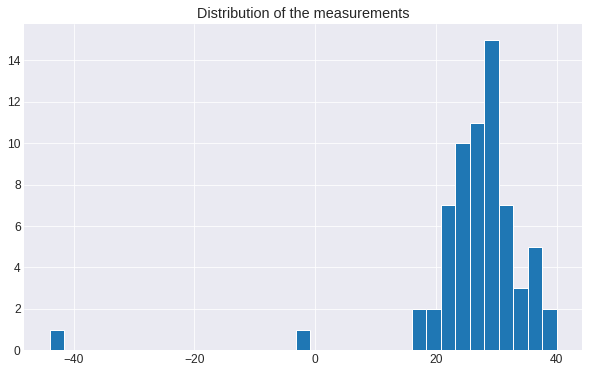

In [9]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(nums, bins=35, edgecolor='w')
plt.title('Distribution of the measurements');

In [10]:
mean_t = np.mean(nums)
print('The mean of the 66 measurements is {:.1f}'.format(mean_t))

The mean of the 66 measurements is 26.2


In [11]:
std_t = np.std(nums, ddof=1)
print('The standard deviation of the 66 measurements is {:.1f}'.format(std_t))

The standard deviation of the 66 measurements is 10.7


And now, we use `pymc3` to estimate the mean and the standard deviation from the data.

In [12]:
with pm.Model() as model_1:
    mu = pm.Uniform('mu', lower=10, upper=30)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    post = pm.Normal('post', mu=mu, sd=sigma, observed=nums)

In [13]:
with model_1:
    trace_1 = pm.sample(draws=50_000, tune=50_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 400000/400000 [02:15<00:00, 2959.58draws/s]
The acceptance probability does not match the target. It is 0.7105000264372134, but should be close to 0.8. Try to increase the number of tuning steps.


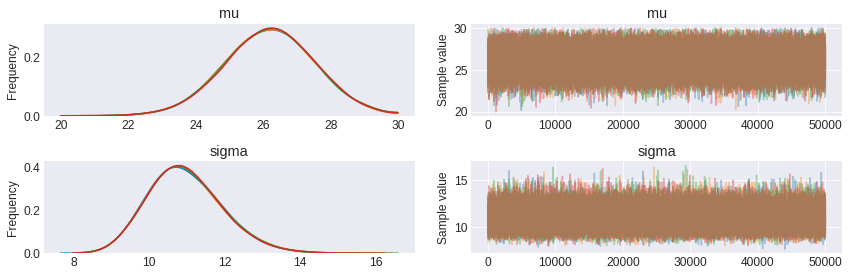

In [14]:
pm.traceplot(trace_1);

In [15]:
df = pm.summary(trace_1)
df.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.1964,1.3316,0.0035,23.5758,28.8209,119401.0332,1.0000
sigma,10.9539,0.9821,0.0027,9.1469,12.9461,110767.6332,1.0000


As you can see, the highest posterior interval for `mu` is [23.57, 28.82].

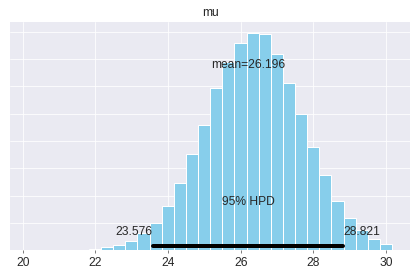

In [16]:
pm.plot_posterior(trace_1, varnames=['mu']);

The true posterior distribution is $t_{65}$

In [17]:
from scipy.stats import t

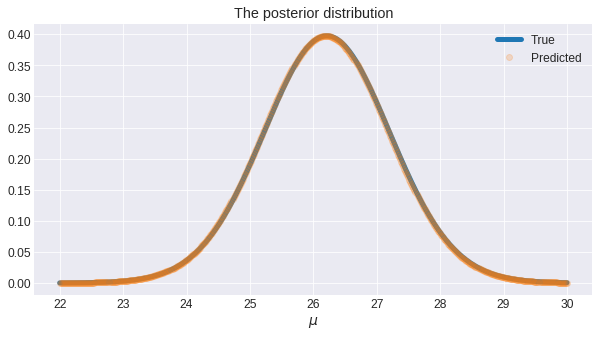

In [18]:
x = np.linspace(22, 30, 500)
y = t.pdf(x, 65, loc=mean_t)

y_pred = t.pdf(x, 65, loc=df['mean'].values[0])

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', alpha=0.2)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\mu$', fontsize=14);

The book says you can find the posterior interval by simulation, so let's do that with Python. First, draw random values of $\sigma^2$ and $\mu$.

In [511]:
mu_estim = []

for i in range(10_000):
    y = np.random.chisquare(65)
    y2 = 65 * std_t**2 / y
    yy = np.random.normal(loc=mean_t, scale=y2/66)
    mu_estim.append(yy)

To visualize `mu_estim`, we plot a histogram.

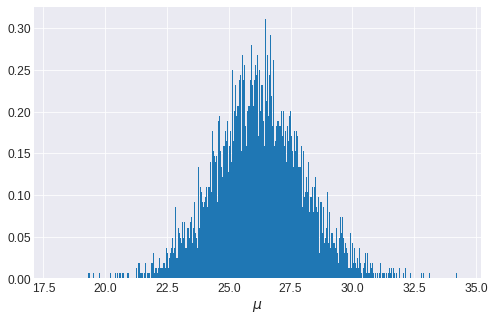

In [512]:
plt.figure(figsize=(8,5))
rang, bins1, _ = plt.hist(mu_estim, bins=1000, density=True)
plt.xlabel(r'$\mu$', fontsize=14);

The advantage here is that you can find the median and the central posterior interval. Well, the median is...

In [518]:
idx = bins1.shape[0] // 2
print((bins1[idx] + bins1[idx + 1]) / 2) 

26.16979790239389


And the central posterior interval is... not that easy to find. We have to find $a$ such as:

$$\int_{\mu -a}^{\mu +a} f(x)\, dx = 0.95,$$

with $

In [496]:
delta_bin = bins1[1] - bins1[0]
idx = bins1.shape[0] // 2
print(idx, delta_bin)
print(bins1[idx])

500 0.019736050898707447
26.3138743671448


In [497]:
def func3(a):
    return sum(rang[idx - int(a):idx + int(a)] * delta_bin) - 0.95

In [498]:
func3(190)

0.0063900000000187696

In [499]:
brentq(func3, 0, idx)

184.00000000000028

In [502]:
bins1[idx - 184]

22.6824410017827

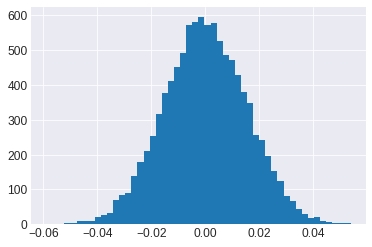

In [492]:
prueba = []

for i in range(10_000):
    prueba.append(np.random.normal(scale=1/65))
    
plt.hist(prueba, bins=50);

In [339]:
from scipy.integrate import quad
from scipy.optimize import brentq

In [ ]:
def func(xx):
    return norm.pdf(xx, mean_t, scale= 1/(std_t**2 / 66))

print(quad(func, 22, 26.1)[0])
print(quad(func, 26.1, 33)[0])

def func2(xx):
    return quad(func, 22, xx)[0] - quad(func, xx, 33)[0]

brentq(func2, 20, 33)

In [ ]:
points = [(x, y) for x, y in zip(x, y)]

ss = []
for i in range(1000000):
    ss.append(np.random.choice(y))

In [ ]:
# sum(ss) / len(ss)
# np.mean(x * y)

np.mean(ss)

In [ ]:
np.trapz(y)

In [ ]:
delta_x = x[78] - x[77]
mea = sum(yy * x * delta_x)

idx = np.abs(yy - mea).argmin()
x[idx]

In [ ]:
def func3(yy, a):
    return sum(yy[idx - int(a):idx + int(a)] * delta_x)

In [ ]:
func3(yy, 37)

In [ ]:
brentq(func3, 0, 10)

In [ ]:
from scipy.stats import dirichlet

In [ ]:
ddd = dirichlet([728, 584, 138])

rad = []
for i in range(10000):
    rad.append(ddd.rvs()[0][0] - ddd.rvs()[0][1])

In [ ]:
tot = plt.hist(rad, bins=20, edgecolor='w', density=True)

In [ ]:
print(sum(tot[0]))

print(sum(
    tot[0] * tot[1][1:] * (tot[1][2] - tot[1][1])
))

In [84]:
import theano.tensor as tt
import theano

In [85]:
mu = theano.shared('mu')
mu.set_value?

In [86]:
with pm.Model() as model_2:
    sigma = 65 * std_t / pm.ChiSquared('sigma', nu=65)
    mu = pm.Normal('mu', mu=20, sd=sigma**2 / 65)
    post = pm.Normal('post', mu=mu, sd=np.sqrt(sigma), observed=nums)

In [87]:
model_2.check_test_point()

sigma_log__      0.82
mu              -1.49
post          -606.75
Name: Log-probability of test_point, dtype: float64

In [88]:
with model_2:
    trace_2 = pm.sample(draws=5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:13<00:00, 3020.04draws/s]


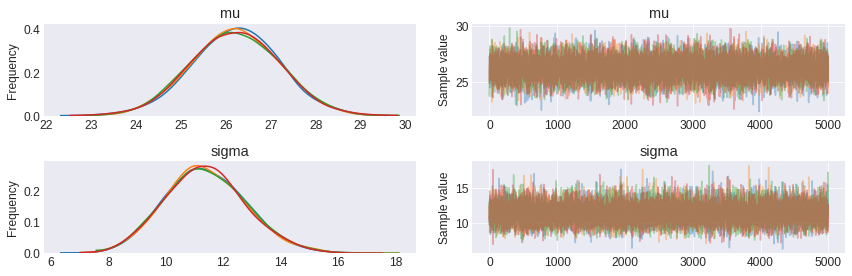

In [89]:
pm.traceplot(trace_2);

In [90]:
pm.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.213152,0.973139,0.007022,24.333732,28.143417,18200.809055,0.999957
sigma,11.395654,1.406132,0.010366,8.693742,14.176203,17910.291842,0.999923


## Example. Pre-election polling

In [91]:
obs = np.array([727, 583, 137])
# total_adut = 1447
bush_supp = obs[0] / sum(obs)
dukakis_supp = obs[1] / sum(obs)
other_supp = obs[2] / sum(obs)

arr = np.array([bush_supp, dukakis_supp, other_supp])
# obs = np.array([727,583,137])
# print(arr.shape, obs.shape)
print('The proportion array is', arr)
print('The supporters array is', obs)

The proportion array is [0.5024188  0.40290256 0.09467865]
The supporters array is [727 583 137]


In [92]:
# def logp(rho, n):
# #     return (-pm.math.log(2 * np.pi) + 1/2 * pm.math.log(1- rho**2)).sum()
#     return (1 / rho**n).sum()

# prior_j = pm.DensityDist('prior_j', logp)

In [379]:
tt.stack?

In [418]:
with pm.Model() as model_3:

    theta1 = pm.Uniform('theta1', lower=0, upper=1)
    theta2 = pm.Uniform('theta2', lower=0, upper=1)
#     print(theta2.var)
#     theta3 = mo
#     theta3 = pm.Uniform('theta3', upper=1, lower=0)
#     theta3 = pm.model.FreeRV(type=)
    post = pm.Multinomial('post', n=obs.sum(), p=tt.stack([theta1, theta2, 0.5]), shape=3, observed=obs)
    diff = pm.Deterministic('diff', theta1 - theta2)

    
# with pm.Model() as m:
#     theta = pm.Dirichlet('theta', a=np.ones_like(obs))
#     post = pm.Multinomial('post', n=obs.sum(), p=theta, observed=obs)
#     trace_n = pm.sample(1000, tune=5000)
#     dirr = pm.Dirichlet('dirr', obs, observed=arr)

In [419]:
model_3.check_test_point()

theta1_interval__     -1.39
theta2_interval__     -1.39
post                -243.49
Name: Log-probability of test_point, dtype: float64

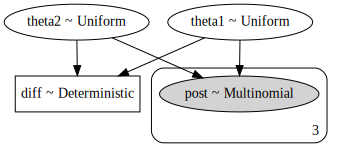

In [420]:
pm.model_to_graphviz(model_3)

In [421]:
with model_3:
    trace_3 = pm.sample(draws=5_000, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:09<00:00, 2661.61draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


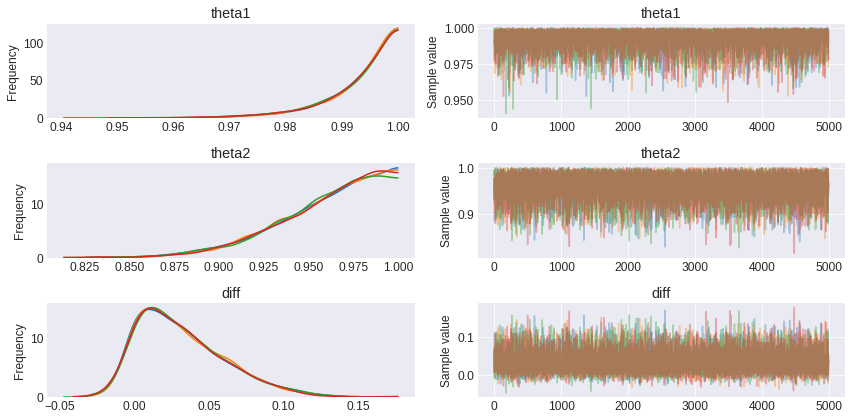

In [422]:
pm.traceplot(trace_3);
# plt.savefig('trace.png', dpi=150)

In [423]:
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.993198,0.006642,0.000060,0.979683,0.999999,9583.196533,1.000070
theta2,0.961312,0.029064,0.000259,0.905269,0.999998,11099.663579,0.999980
diff,0.031886,0.029565,0.000255,-0.014142,0.092340,11431.520743,0.999974


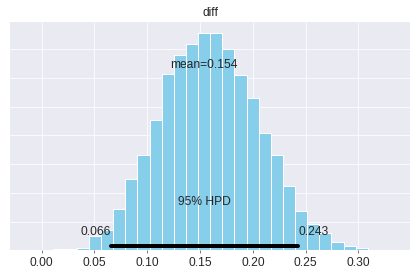

In [130]:
pm.plot_posterior(trace_3, varnames=['diff']);

In [399]:
pm.diagnostics.effective_n(trace_3)

{'theta1': 86.70742362475485,
 'theta2': 89.83334802122506,
 'theta3': 92.09320835687406,
 'diff': 185.12792889770142}

<Figure size 720x432 with 0 Axes>

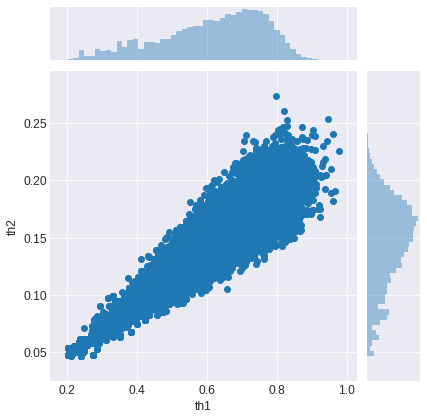

In [400]:
x = pd.Series(trace_3['theta2'], name='th1')
y = pd.Series(trace_3['theta3'], name='th2')

plt.figure(figsize=(10,6))
sns.jointplot(x, y, kind='scatter');